# Image Datasets

> Image datasets

In [ ]:
#| default_exp image.datasets

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

import torch
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from lightning import LightningDataModule

import pandas as pd
from matplotlib import pyplot as plt
plt.set_loglevel('INFO')

import os

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Any, Dict, Optional, Tuple, List
from nimrod.data.core import DataModule
from nimrod.utils import set_seed

import logging
logger = logging.getLogger(__name__)

In [ ]:
set_seed(42)

Seed set to 42


## ImageDataset base class

In [ ]:
#| export
class ImageDataset(Dataset):
    " Base class for image datasets providing visualization of (image, label) samples"

    def __init__(self):
        logger.info("ImageDataset: init")
        super().__init__()

    def show_idx(self,
            index:int # Index of the (image,label) sample to visualize
        ):
        "display image from data point index of a image dataset"
        X, y = self.__getitem__(index)
        plt.figure(figsize = (1, 1))
        plt.imshow(X.numpy().reshape(28,28),cmap='gray')
        plt.title(f"Label: {int(y)}")
        plt.show()

    @staticmethod
    def show_grid(
            imgs: List[torch.Tensor], # python list of images dim (C,H,W)
            save_path=None, # path where image can be saved
            dims:Tuple[int,int] = (28,28)
        ):
        "display list of mnist-like images (C,H,W)"
        if not isinstance(imgs, list):
            imgs = [imgs]
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            axs[0, i].imshow(img.numpy().reshape(dims[0],dims[1]))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if save_path:
            plt.savefig(save_path)

    def show_random(
            self,
            n:int=3, # number of images to display
            dims:Tuple[int,int] = (28,28)
        ):
        "display grid of random images"
        indices = torch.randint(0,len(self), (n,))
        images = []
        for index in indices:
            X, y = self.__getitem__(index)
            X = X.reshape(dims[0],dims[1])
            images.append(X)
        self.show_grid(images)
        

In [ ]:
show_doc(ImageDataset.show_idx)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/image/datasets.py#L39){target="_blank" style="float:right; font-size:smaller"}

### ImageDataset.show_idx

>      ImageDataset.show_idx (index:int)

*display image from data point index of a image dataset*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| index | int | Index of the (image,label) sample to visualize |

## MNIST

### MNIST dataset

In [ ]:
#| export 

class MNISTDataset(ImageDataset):
    "MNIST digit dataset"

    def __init__(
        self,
        data_dir:str='../data/image', # path where data is saved
        train = True, # train or test dataset
        transform:torchvision.transforms.transforms=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
        # TODO: add noramlization?
        # torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(0.1307,), (0.3081,))])

    ):
        os.makedirs(data_dir, exist_ok=True)
        super().__init__()
        logger.info("MNISTDataset: init")

        self.ds = MNIST(
            data_dir,
            train = train,
            transform=transform, 
            download=True
        )

    def __len__(self) -> int: # length of dataset
        return len(self.ds)
    
    def __getitem__(self, idx # index into the dataset
                    ) -> tuple[torch.FloatTensor, int]: # Y image data, x digit number
        x = self.ds[idx][0]
        y = self.ds[idx][1]
        return x, y
    
    def train_dev_split(
            self,
            ratio:float, # percentage of train/dev split,
        ) -> tuple[torchvision.datasets.MNIST, torchvision.datasets.MNIST]: # train and set mnnist datasets

        train_set_size = int(len(self.ds) * ratio)
        valid_set_size = len(self.ds) - train_set_size

        # split the train set into two
        train_set, valid_set = data.random_split(self.ds, [train_set_size, valid_set_size])
        # TODO: cast to ImageDataset to allow for drawing
        # train_set, valid_set = Dataset(train_set),j Dataset(valid_set)
        return train_set, valid_set



In [ ]:
show_doc(MNISTDataset.train_dev_split)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/image/datasets.py#L110){target="_blank" style="float:right; font-size:smaller"}

### MNISTDataset.train_dev_split

>      MNISTDataset.train_dev_split (ratio:float, seed:int=42)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ratio | float |  | percentage of train/dev split, |
| seed | int | 42 | rand generator seed |
| **Returns** | **tuple** |  | **train and set mnnist datasets** |

### Usage
Setup MNIST dataset. Download data if not found in specified location.

[12/20/24 12:55:31] INFO     2024-12-20 12:55:31,947 - INFO - ImageDataset: init                    ]8;id=659172;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_82738/2189827711.py\2189827711.py]8;;\:]8;id=584632;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_82738/2189827711.py#6\6]8;;\

                    INFO     2024-12-20 12:55:31,948 - INFO - MNISTDataset: init                    ]8;id=193818;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_82738/354163277.py\354163277.py]8;;\:]8;id=155457;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_82738/354163277.py#20\20]8;;\

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:14<00:00, 706003.45it/s] 


Extracting ../data/image/test/MNIST/raw/train-images-idx3-ubyte.gz to ../data/image/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132486.04it/s]


Extracting ../data/image/test/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/image/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 258889.72it/s]


Extracting ../data/image/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/image/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1950899.00it/s]

Extracting ../data/image/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/image/test/MNIST/raw

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/image/test
    Split: Test
    StandardTransform
Transform: ToTensor() torch.float32 <class 'int'>
Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor <class 'int'>


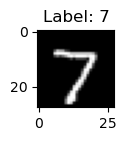

In [ ]:
# define test set (train=False)
test = MNISTDataset('../data/image', train=False, transform=transforms.ToTensor())

# output ( (C,H,W), int)
print(test.ds, test.ds[0][0].dtype, type(test.ds[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show_idx(0)

# split data
train, dev = test.train_dev_split(0.8)

### Instantiate from config file
It is convenient to keep setup of specific dataset for an experiment in a config file for reproductibility

{'_target_': 'nimrod.image.datasets.MNISTDataset', 'data_dir': '../data/image', 'train': False, 'transform': {'_target_': 'torchvision.transforms.ToTensor'}}
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/image
    Split: Test
    StandardTransform
Transform: ToTensor() torch.float32 <class 'int'>
Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor <class 'int'>


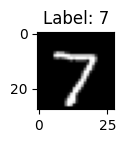

In [ ]:
# instantiate dataset from yaml config file
cfg = OmegaConf.load("../config/image/data/mnist.yaml")
print(cfg.dataset)
test = instantiate(cfg.dataset)
type(test)

# output ( (B,C, H,W), int)
print(test.ds, test.ds[0][0].dtype, type(test.ds[0][1]))
print(f"Number of samples in the dataset: {len(test)}")

# get item helper
X, y = test[0]
print(X.shape, y, X.type(), type(y))

# display each digit
test.show_idx(0)

# split data
train, dev = test.train_dev_split(0.8)


### MNIST DataModule

In [ ]:
#| export

class MNISTDataModule(DataModule, LightningDataModule):
    def __init__(self,
                 data_dir: str | os.PathLike = "~/Data/", # path to source data dir
                 train_val_test_split:List[float] = [0.8, 0.1, 0.1], # train val test %
                 batch_size: int = 64, # size of compute batch
                 num_workers: int = 0, # num_workers equal 0 means that it’s the main process that will do the data loading when needed, num_workers equal 1 is the same as any n, but you’ll only have a single worker, so it might be slow
                 pin_memory: bool = False, # If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory. This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer
                 persistent_workers: bool = False
                 ):

        logger.info("Init MNIST DataModule")
        super().__init__(train_val_test_split, batch_size, num_workers, pin_memory, persistent_workers)
        self.save_hyperparameters()

    @property
    def num_classes(self) -> int: # num of classes in dataset
        return 10

    def prepare_data(self) -> None:
        """Download data if needed + format with MNISTDataset
        """
        # train set
        MNISTDataset(self.hparams.data_dir, train=True)
        # test set
        MNISTDataset(self.hparams.data_dir, train=False)

    def setup(self, stage: Optional[str] = None) -> None:
        # stage: {fit,validate,test,predict}\n",
        # concat train & test mnist dataset and randomly generate train, eval, test sets
        if not self.data_train or not self.data_val or not self.data_test:
            # ((B, H, W), int)
            trainset = MNISTDataset(self.hparams.data_dir, train=True, transform=self.transforms)
            testset = MNISTDataset(self.hparams.data_dir, train=False, transform=self.transforms)
            dataset = ConcatDataset(datasets=[trainset, testset])
            # TODO: keep test set untouched
            lengths = [int(split * len(dataset)) for split in self.hparams.train_val_test_split]
            self.data_train, self.data_val, self.data_test = random_split(dataset=dataset, lengths=lengths)
        

In [ ]:
from pprint import pprint
# check for abstract methods
pprint([(name, getattr(method,"__isabstractmethod__", False)) for (name, method) in DataModule.__dict__.items()])


[('__module__', False),
 ('__init__', False),
 ('prepare_data', True),
 ('setup', True),
 ('train_dataloader', False),
 ('val_dataloader', False),
 ('test_dataloader', False),
 ('teardown', False),
 ('state_dict', False),
 ('load_state_dict', False),
 ('__dict__', False),
 ('__weakref__', False),
 ('__doc__', False),
 ('__abstractmethods__', False),
 ('_abc_impl', False)]


### Usage

2024-12-15 17:04:53,863 - INFO - Init MNIST DataModule


56000 7000 7000
X dim(B,C,W,H):  torch.Size([64, 1, 28, 28]) Y: dim(B) torch.Size([64])
torch.Size([1, 28, 28])
2 None
[0, 4, 8, 8, 4]


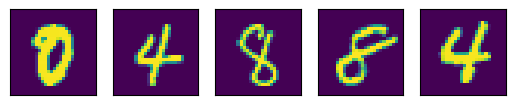

In [ ]:
# init
dm = MNISTDataModule(
    data_dir="../data/image",
    train_val_test_split=[0.8, 0.1, 0.1],
    batch_size = 64,
    num_workers = 0, # main process
    pin_memory= False,
    persistent_workers=False
)

# download or reference data from dir
dm.prepare_data()

# define train, eval, test subsets
dm.setup()

# len of splits
print(len(dm.data_train), len(dm.data_val), len(dm.data_test))

# access data batches via dataloader
test_dl = dm.test_dataloader()
X,Y = next(iter(test_dl))
print("X dim(B,C,W,H): ", X.shape, "Y: dim(B)", Y.shape)

# access data points directly by index
print(len(dm.data_test[0]), print(dm.data_test[0][0].shape))
imgs = [dm.data_test[i][0] for i in range(5)]

# display image samples
ImageDataset.show_grid(imgs)

# labels are ints
lbls = [dm.data_test[i][1] for i in range(5)]
print(lbls)

### Config

2024-12-15 17:09:44,673 - INFO - Init MNIST DataModule


{'_target_': 'nimrod.image.datasets.MNISTDataModule', 'data_dir': '../data/image', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 64, 'num_workers': 1, 'pin_memory': False, 'persistent_workers': False}
<class 'nimrod.image.datasets.MNISTDataModule'>


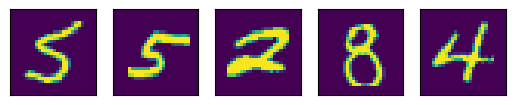

In [ ]:
cfg = OmegaConf.load("../config/image/data/mnist.yaml")
print(cfg.datamodule)
dm = instantiate(cfg.datamodule)
dm.prepare_data()
dm.setup()
test_dl = dm.test_dataloader()
len(dm.data_test[0])
imgs = [dm.data_test[i][0] for i in range(5)]
ImageDataset.show_grid(imgs)
print(type(dm))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()